In [1]:
from matplotlib import pyplot as plt
from matplotlib import animation
import ConfigModel_MCMC as CM

import networkx as nx
import numpy as np
import numpy.ma as ma
import pandas as pd
import seaborn as sns

In [2]:
def truncated_power_law(gamma, k_0, n, size=None):
    """
    Generate a sample of size *size* from a power law distribution
    with mininmum *k_0*, maximum *n*, and power *gamma*
    """
    k_0=np.float64(k_0)
    gamma=np.float64(gamma)
    n=np.float64(n)
    
    if size:
        U = rng.uniform(size=size)
    else:
        U = rng.uniform()
        
    return (
        (k_0**(1-gamma) - 
             ( k_0**(1-gamma) - n**(1-gamma) ) * U 
        )**(1/(1-gamma))
    )

In [3]:
rng = np.random.default_rng(2357111)

gamma = 2.4
k_0 = 2
n = 100
size=100

k = truncated_power_law(gamma, k_0, n, size=size).astype(int)
k.sort()
k

array([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,
        4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,
        7,  8,  8, 10, 11, 12, 12, 15, 15, 22, 23, 39, 45, 51, 59])

In [4]:
k.mean()

5.83

In [5]:
def generate_chung_lu(k):
    n = len(k)

    k_mean = k.mean()
    # k_mean times is twice the expected number of edges
    # this will be the denominator of all edge probabilities
    m2 = k_mean * n

    # initialize adjacency matrix
    A = np.zeros((n,n),dtype=int)
    choices = rng.random(n*(n-1) // 2)
    choice_i = 0
    
    for i in range(n):
        for j in range(i+1,n):
            # no self loops
            if i == j:
                continue
                
            # compute probability of edge
            p = min(
                (k[i] * k[j] / m2,
                1))
            
            # generate edge
            if choices[choice_i] < p:
                A[i,j] = 1
                A[j,i] = 1
            
            choice_i += 1
                
    return A

A = generate_chung_lu(k)
A.sum(axis=1).mean()

5.22

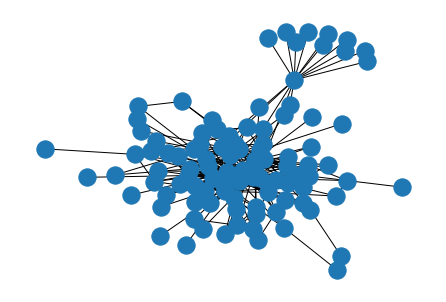

In [6]:
k = A.sum(axis=0)
disco = np.where(k==0)

for i in disco:
    j = rng.choice(n)
    A[i,j] = 1
    A[j,i] = 1
    
G = nx.convert_matrix.from_numpy_array(A)
pos = nx.spring_layout(G, seed=3113794652)

nx.draw(G,pos)

In [31]:
def run_sim(n_iter, X, eps, M, minfriends, minbad):
    Xs = [X]
    for _ in range(n_iter):
        if X.sum() < M:
            # go if enough of your friends went last week
            # whether or not you went
            X = (A.dot(X) > minfriends)
        else:
            X = (A.dot(X) > minbad)

        X += rng.uniform(size=(100,1)) < eps
        Xs.append(X)
    return np.hstack(Xs)


rng = np.random.default_rng(11235813)

eps = 0
M = 60
minfriends = 2
minbad = 5
n_iter = 1000

Xnps = []

for i in range(30):
    X = rng.uniform(size=(100,1)) < 0.3
    Xnps.append(
        run_sim(n_iter, X, eps, M, minfriends, minbad))
    print(f"Ran simulation {i}")
    
    
# skip first 50 rounds to give time to settle
attendance = [np.where(Xnp[:,50:]) for Xnp in Xnps]
ppl = [pd.Series(a[0]) for a in attendance]

cnts = pd.DataFrame(index=range(100))
for i in range(30):
    cnts[i] = ppl[i].value_counts()

    
always = (cnts==951).mean(axis=1)
sometimes = (cnts < 951).mean(axis=1)
never = cnts.isna().mean(axis=1)

cnts["Always"] = always
cnts["Sometimes"] = sometimes
cnts["Never"] = never
cnts["Degree"] = pd.Series({node:val for (node, val) in G.degree()})
cnts["Triangles"] = pd.Series(nx.triangles(G))
cnts["Eigenvec"] = pd.Series(nx.algorithms.centrality.eigenvector_centrality(G))

Ran simulation 0
Ran simulation 1
Ran simulation 2
Ran simulation 3
Ran simulation 4
Ran simulation 5
Ran simulation 6
Ran simulation 7
Ran simulation 8
Ran simulation 9
Ran simulation 10
Ran simulation 11
Ran simulation 12
Ran simulation 13
Ran simulation 14
Ran simulation 15
Ran simulation 16
Ran simulation 17
Ran simulation 18
Ran simulation 19
Ran simulation 20
Ran simulation 21
Ran simulation 22
Ran simulation 23
Ran simulation 24
Ran simulation 25
Ran simulation 26
Ran simulation 27
Ran simulation 28
Ran simulation 29


In [33]:
cnts

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,Always,Sometimes,Never,Degree,Triangles,Eigenvec
0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,...,951.0,951.0,951.0,951.0,1.0,0.0,0.0,5,2,0.066841
1,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,...,951.0,951.0,951.0,951.0,1.0,0.0,0.0,4,3,0.074934
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,1.0,3,0,0.019231
3,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,...,951.0,951.0,951.0,951.0,1.0,0.0,0.0,5,3,0.045728
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,1.0,2,1,0.039034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,...,951.0,951.0,951.0,951.0,1.0,0.0,0.0,24,59,0.280570
96,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,...,951.0,951.0,951.0,951.0,1.0,0.0,0.0,29,52,0.277479
97,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,...,951.0,951.0,951.0,951.0,1.0,0.0,0.0,29,67,0.299376
98,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,951.0,...,951.0,951.0,951.0,951.0,1.0,0.0,0.0,26,69,0.304366


In [34]:
cnts.Always.value_counts()

1.0    55
0.0    45
Name: Always, dtype: int64

In [35]:
cnts.Never.value_counts()

0.000000    55
1.000000    42
0.933333     3
Name: Never, dtype: int64

In [36]:
cnts.Sometimes.value_counts()

0.000000    97
0.066667     3
Name: Sometimes, dtype: int64

In [50]:
cnts[["Always", "Never", "Triangles", "Eigenvec", "Degree"]].corr()

,Always,Never,Triangles,Eigenvec,Degree
Always,1.000000,-0.999746,0.376629,0.591108,0.508536
Never,-0.999746,1.000000,-0.376654,-0.592166,-0.509407
Triangles,0.376629,-0.376654,1.000000,0.941919,0.953917
Eigenvec,0.591108,-0.592166,0.941919,1.000000,0.954822
Degree,0.508536,-0.509407,0.953917,0.954822,1.000000


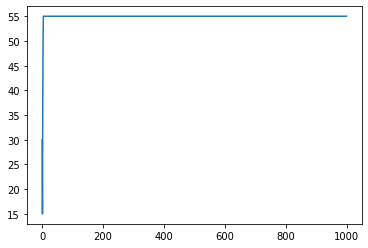

In [40]:
plt.plot(np.ravel(Xnps[0].sum(axis=0)))

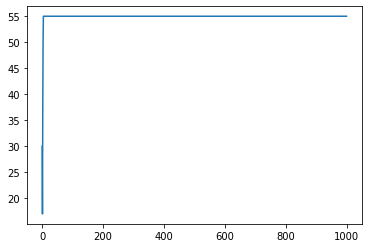

In [41]:
plt.plot(np.ravel(Xnps[1].sum(axis=0)))

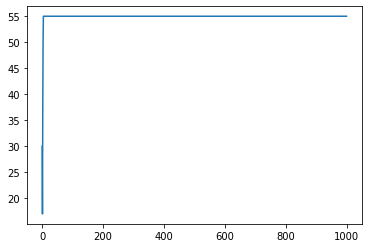

In [42]:
plt.plot(np.ravel(Xnps[1].sum(axis=0)))

<AxesSubplot:>

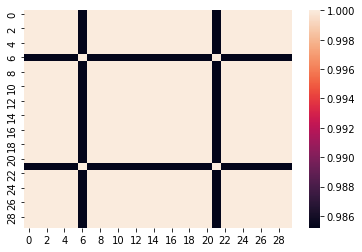

In [49]:
sns.heatmap(cnts[cnts.columns[:30]].fillna(0).corr())

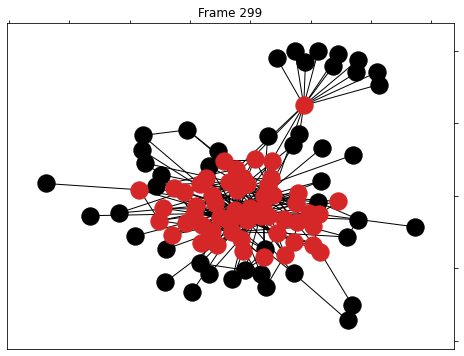

In [53]:
def animate_step(t, Xnp, pos, G, ax):
    ax.clear()

    went = np.where([Xnp[:,t]])[1]
    home = np.where([1 - Xnp[:,t]])[1]

    nx.draw_networkx_nodes(G, pos, nodelist=home, node_color="black")
    nx.draw_networkx_nodes(G, pos, nodelist=went, node_color="tab:red")

    nx.draw_networkx_edges(G, pos)

    # Set the title
    ax.set_title("Frame {}".format(t))
    
    
def make_animation(Xnp, title):
    fig, ax = plt.subplots(figsize=(8,6))
    ani = animation.FuncAnimation(fig, animate_step, frames=Xnp.shape[1], fargs=(Xnp, pos, G, ax))
    ani.save(title, writer="pillow")
    
    
make_animation(Xnps[0][:,-300:], "../images/strategy_config_model_trial_0.gif")

That was the worst animation I've ever seen!  How did it get there?

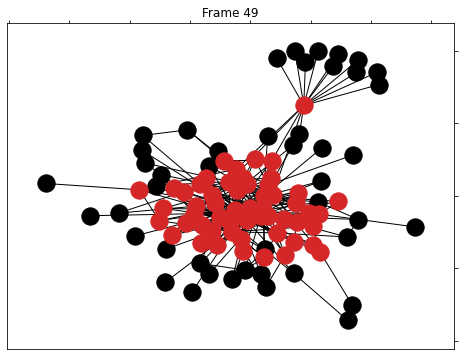

In [54]:
make_animation(Xnps[0][:,:50], "../images/strategy_config_model_trial_0_startt.gif")

So this does have a nice spreading thing until it gets everywhere it can spread.

Takeaways:

Configuration model winds up pretty much deterministic with heterogeneous degree sequence.  Maybe I should try a more homogeneous degree sequence but fuck it life is short.  Let's do some evolution!